久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第6章 GLMの応用範囲を広げる ---ロジスティック回帰など---

ポアソン分布・対数リンク関数の組み合わせ以外も使ってみよう、の章。

## 6.1 さまざまな種類のデータで応用できるGLM（p.114）

表6.1に近いものが http://juliastats.github.io/GLM.jl/stable/manual/#Fitting-GLM-models-1 に載っている。

| 確率分布     | family指定           | 正準リンク関数 |
| ------------ | -------------------- | -----------------|
| [二項分布](https://ja.wikipedia.org/w/index.php?title=%E4%BA%8C%E9%A0%85%E5%88%86%E5%B8%83)     | `Binomial()`         | `LogitLink()`    |
| [ポアソン分布](https://ja.wikipedia.org/wiki/%E3%83%9D%E3%82%A2%E3%82%BD%E3%83%B3%E5%88%86%E5%B8%83) | `Poisson()`          | `LogLink()`      |
| [負の二項分布](https://ja.wikipedia.org/wiki/%E8%B2%A0%E3%81%AE%E4%BA%8C%E9%A0%85%E5%88%86%E5%B8%83) | `NegativeBinomial()` | `LogLink()`      |
| [ガンマ分布](https://ja.wikipedia.org/wiki/%E3%82%AC%E3%83%B3%E3%83%9E%E5%88%86%E5%B8%83)   | `Gamma ()`           | `InverseLink()`  |
| [正規分布](https://ja.wikipedia.org/wiki/%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83)     | `Normal()`           | `IdentityLink()` |

Distributions.jlが入れてあれば、

* 確率密度関数は`pdf(Normal(mu, sigma), x)`
* 累積分布関数は`cdf(Normal(mu, sigma), x)`
* 乱数生成は`rand(Normal(mu, sigma), n)`

のように使える。

In [172]:
using DataFrames
using CSV
using Distributions
using GLM
using Plots

## 6.2 例題：上限のあるカウントデータ（p.115）

In [173]:
d = CSV.read("data4a.csv")
describe(d)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,DataType
1,N,8.0,8,8.0,8,,0,Int64
2,y,5.08,0,6.0,8,,0,Int64
3,x,9.9672,7.66,9.965,12.44,,0,Float64
4,f,,C,,T,2,0,String


In [174]:
@df d scatter(:x, :y, group=:f)

LoadError: UndefVarError: @df not defined

## 6.3 二項分布で表現する「あり・なし」カウントデータ（p.118）

$$ p\left(y | N, q\right) = 
\left(\begin{array}\\
N\\
y\end{array}\right) q^y \left(1-q\right)^{N-y} $$

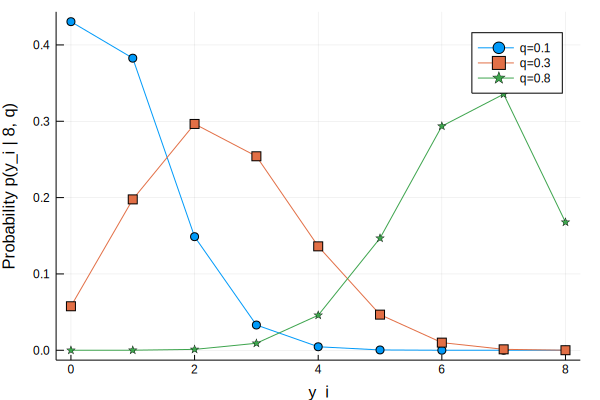

In [175]:
y = 0:8
plot(y, pdf.(Binomial(8, 0.1), y), marker=:auto, label="q=0.1", xlabel="y_i", ylabel="Probability p(y_i | 8, q)")
plot!(y, pdf.(Binomial(8, 0.3), y), marker=:auto, label="q=0.3")
plot!(y, pdf.(Binomial(8, 0.8), y), marker=:auto, label="q=0.8")

## 6.4 ロジスティック回帰とロジットリンク関数

### 6.4.1 ロジットリンク関数（p.119）

**ロジスティック関数**（_logistic function_）
$$ q_i = \mathrm{logistic}\left(z_i\right) = \frac{1}{1 + exp\left(-z_i\right)} $$
$$ z_i = \beta_1 + \beta_2 x_i + \cdots $$

Distribution.jlの`Logistic()`と線形予測子の部分の定義が違う（Logisticではbeta1の正負が逆で、beta2を負値にできなくて、スケールが2倍）っぽいのでどうしようかなぁ、というところ。

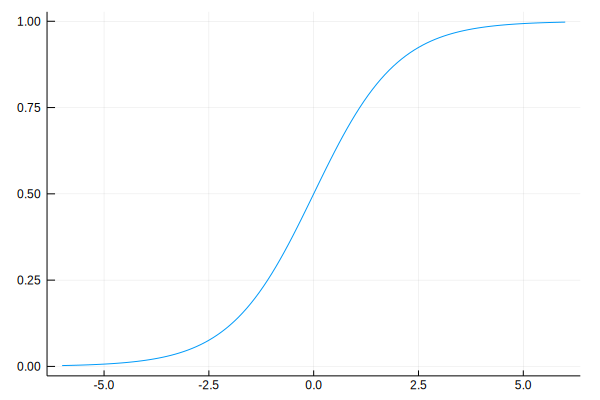

In [176]:
z = range(-6, stop=6, step=0.1)
plot(z, cdf.(Logistic(), z), legend=false)

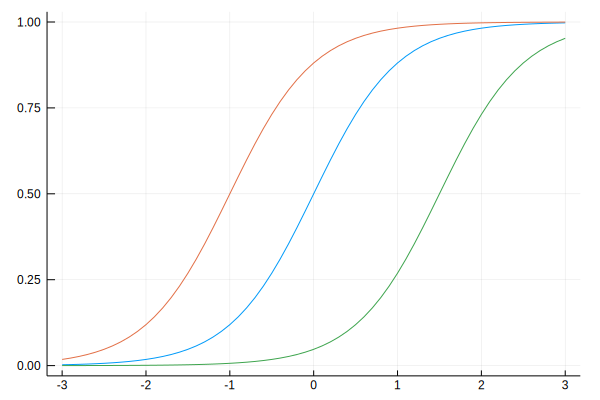

In [177]:
z = range(-3, stop=3, step=0.1)
plot(z, cdf.(Logistic(0, 1/2), z), legend=false)
plot!(z, cdf.(Logistic(-2/2, 1/2), z))
plot!(z, cdf.(Logistic(3/2, 1/2), z))

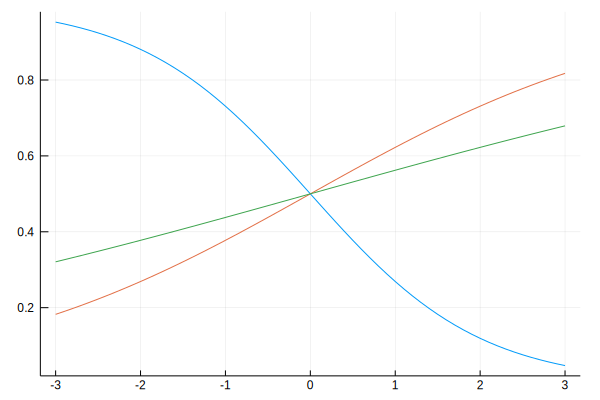

In [178]:
z = range(-3, stop=3, step=0.1)
plot(z, 1 .- cdf.(Logistic(0, 1), z), legend=false)
plot!(z, cdf.(Logistic(0, 2), z))
plot!(z, cdf.(Logistic(0, 4), z))

**ロジット関数**（_logit function_）はロジスティック関数の逆関数
$$ \log\frac{q_i}{1 - q_i} = z_i $$
$$ \mathrm{logit}\left(q_i\right) = \log\frac{q_i}{1 - q_i} $$

### 6.4.2 パラメータ推定（p.122）

In [179]:
glm(@formula(y ~ x + f), d, Binomial(8), LogitLink())

ArgumentError: ArgumentError: 6.0 in y is not in [0,1]

In [180]:
?NegativeBinomial

search: NegativeBinomial NegativeBinomialLink



```
NegativeBinomial(r,p)
```

A *Negative binomial distribution* describes the number of failures before the `r`th success in a sequence of independent Bernoulli trials. It is parameterized by `r`, the number of successes, and `p`, the probability of success in an individual trial.

$$
P(X = k) = {k + r - 1 \choose k} p^r (1 - p)^k, \quad \text{for } k = 0,1,2,\ldots.
$$

The distribution remains well-defined for any positive `r`, in which case

$$
P(X = k) = \frac{\Gamma(k+r)}{k! \Gamma(r)} p^r (1 - p)^k, \quad \text{for } k = 0,1,2,\ldots.
$$

```julia
NegativeBinomial()        # Negative binomial distribution with r = 1 and p = 0.5
NegativeBinomial(r, p)    # Negative binomial distribution with r successes and success rate p

params(d)       # Get the parameters, i.e. (r, p)
succprob(d)     # Get the success rate, i.e. p
failprob(d)     # Get the failure rate, i.e. 1 - p
```

External links:

  * [Negative binomial distribution on Wikipedia](http://en.wikipedia.org/wiki/Negative_binomial_distribution)
